<a href="https://colab.research.google.com/github/Mohamedtahaahmedtaha/Sentiment-Analysis-for-Mental-Health/blob/main/Sentiment_Analysis_for_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
suchintikasarkar_sentiment_analysis_for_mental_health_path = kagglehub.dataset_download('suchintikasarkar/sentiment-analysis-for-mental-health')

print('Data source import complete.')


Data source import complete.


In [10]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('/content/Combined Data.csv')


In [13]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [14]:
data.shape

(53043, 3)

In [15]:
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [16]:
print("Missing Values:")
print(data.isna().sum())

Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [17]:
data.isna().sum()/len(data)

,0
Unnamed: 0,0.000000
statement,0.006825
status,0.000000


In [18]:
#data.dropna(inplace=True)
#data.info()

In [19]:
data['statement'] = data['statement'].fillna('')

In [24]:
fig = px.histogram(data, x='status', title='Distribution of Mental Health Status', color="status")
fig.show()

In [21]:
data['text_length'] = data['statement'].apply(lambda x: len(str(x).split()))
fig = px.histogram(data, x='text_length', title='Text Length Distribution')
fig.show()

In [25]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

data['cleaned_statement'] = data['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [26]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_statement'] = data['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [28]:
# Data Augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

data['augmented_statement'] = data['statement'].apply(augment_text)
augmented_df = data[['statement', 'status']].copy()
augmented_df['statement'] = data['augmented_statement']
data = pd.concat([data, augmented_df])

In [29]:
# Reapply preprocessing on augmented data
data['cleaned_statement'] = data['statement'].apply(lambda x: preprocess_text(x))
data['cleaned_statement'] = data['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [30]:
data['cleaned_statement'] = data['cleaned_statement'].fillna('')

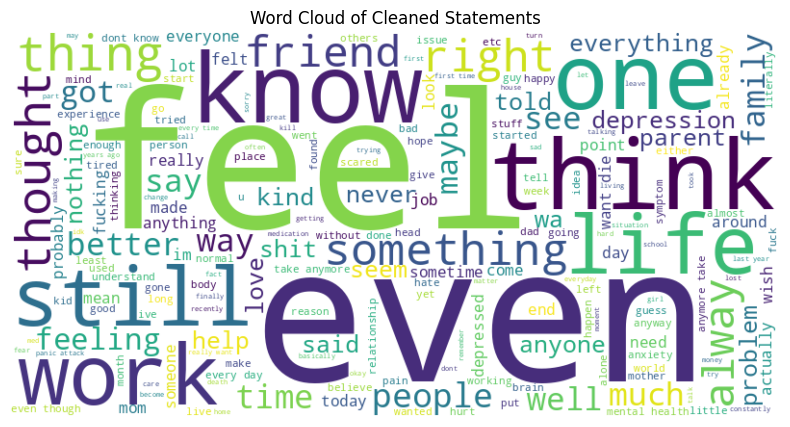

In [31]:
# Word Cloud
all_text = ' '.join(data['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()

In [32]:
# Status Distribution
fig = px.pie(data, names='status', title='Proportion of Each Status Category')
fig.show()

In [33]:
# Splitting the data
X = data['cleaned_statement']
y = data['status']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [36]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [37]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [38]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'C': 100}
Accuracy Score:
0.8660571213120936
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.92      0.91      0.92      1562
             Bipolar       0.93      0.90      0.92      1150
          Depression       0.83      0.83      0.83      6182
              Normal       0.93      0.96      0.94      6571
Personality disorder       0.85      0.81      0.83       447
              Stress       0.89      0.86      0.87      1047
            Suicidal       0.78      0.77      0.77      4259

            accuracy                           0.87     21218
           macro avg       0.88      0.86      0.87     21218
        weighted avg       0.87      0.87      0.87     21218



In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

In [40]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}')
    fig.show()